In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sagemaker
import boto3
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns',None) # To display all columns
pd.set_option('display.max_rows',None) # To display all columns
client = boto3.client('s3')
import feather
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
KT1=pd.read_feather('s3://haseebdata/EDNET DATA/Ednet feather files/KT1.ftr')
questions_df = pd.read_csv('s3://haseebdata/EDNET DATA/EDNET Content CSV/questions.csv')

In [3]:
KT1.head()

,timestamp,solving_id,question_id,user_answer,elapsed_time,user_iD
0,1565096190868,1,q5012,b,38000,1
1,1565096221062,2,q4706,c,24000,1
2,1565096293432,3,q4366,b,68000,1
3,1565096339668,4,q4829,a,42000,1
4,1565096401774,5,q6528,b,59000,1


In [10]:
questions_df.bundle_id = questions_df.bundle_id.str.slice(start=1)
questions_df.explanation_id = questions_df.explanation_id.str.slice(start=1)
questions_df.deployed_at = pd.to_datetime(questions_df.deployed_at, unit='ms')
dfq = questions_df[['question_id', 'correct_answer', 'bundle_id', 'explanation_id' , 'part', 'tags', 'deployed_at']]
dfq.head()

,question_id,correct_answer,bundle_id,explanation_id,part,tags,deployed_at
0,q1,b,1,1,1,1;2;179;181,2019-05-17 11:40:17.098
1,q2,a,2,2,1,15;2;182,2019-05-17 11:40:19.720
2,q3,b,3,3,1,14;2;179;183,2019-05-17 11:40:22.784
3,q4,b,4,4,1,9;2;179;184,2019-05-17 11:40:25.357
4,q5,c,5,5,1,8;2;179;181,2019-05-17 11:40:28.439


In [41]:
KT1['user_iD'].nunique()

289886

In [43]:
KT1.isnull().values.any()

True

In [45]:
KT1.isnull().sum()

timestamp           0
solving_id          0
question_id         0
user_answer     23671
elapsed_time        0
user_iD             0
dtype: int64

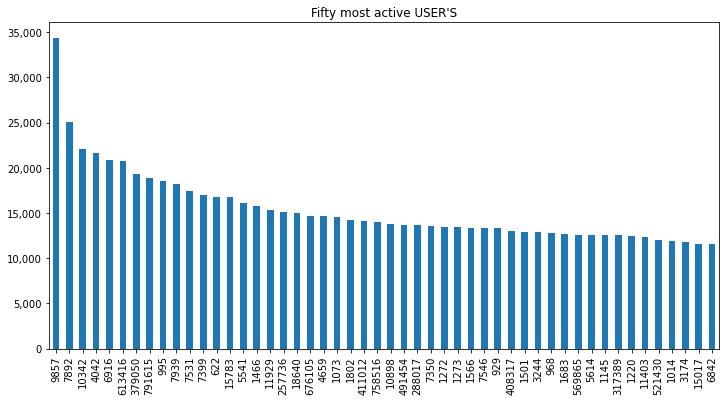

In [47]:
cids = KT1.user_iD.value_counts()[:50]

fig = plt.figure(figsize=(12,6))
ax = cids.plot.bar()
plt.title("Fifty most active USER'S")
plt.xticks(rotation=90)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()

In [49]:
# left join student dataframe and answer key dataframe on the 'question_id' column 
dfm = pd.merge(KT1, dfq,  how='left', left_on=['question_id'], right_on = ['question_id'])

In [50]:
# create a 'correct' column
dfm['correct'] = np.nan

# loop - if user answers == correct answer, then dfq['correct'][_]= 1
length_df = dfm['user_iD'].count()
count = 0
for i in range(length_df):
    if dfm['user_answer'][count] == dfm['correct_answer'][count]:
        dfm['correct'][count] = 1
    if dfm['user_answer'][count] != dfm['correct_answer'][count]:
        dfm['correct'][count] = 0
    count+=1

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [51]:
df_total_questions_attempted = dfm.groupby(['user_iD'], as_index=False , sort=False)['question_id'].count()

df_total_questions_attempted = df_total_questions_attempted.rename(columns={'question_id': 'Total Questions Attempted'})

df_total_questions_attempted.head()                                                                

,user_iD,Total Questions Attempted
0,1,1082
1,10,16
2,100,33
3,1000,1488
4,10004,2486


In [52]:
df_correct = dfm[dfm['correct']==1].groupby(['user_iD'], as_index=False, sort=False)['question_id'].count()

df_correct = df_correct.rename(columns={'question_id': 'Corrected'})

df_correct.head()

,user_iD,Corrected
0,1,753
1,10,9
2,100,18
3,1000,930
4,10004,1790


In [53]:
df_incorrect = dfm[dfm['correct']==0].groupby(['user_iD'], as_index=False, sort=False)['question_id'].count()

df_incorrect = df_incorrect.rename(columns={'question_id': 'Incorrected'})

df_incorrect.head()

,user_iD,Incorrected
0,1,329
1,10,7
2,100,15
3,1000,558
4,10004,696


In [54]:
dfs = [df_total_questions_attempted, df_correct, df_incorrect]
df_final = reduce(lambda left,right: pd.merge(left,right,on='user_iD'), dfs)

In [55]:
df_final['Percentage'] = (df_final['Corrected'] / df_final['Total Questions Attempted']) *100
df_final.head()

,user_iD,Total Questions Attempted,Corrected,Incorrected,Percentage
0,1,1082,753,329,69.593346
1,10,16,9,7,56.250000
2,100,33,18,15,54.545455
3,1000,1488,930,558,62.500000
4,10004,2486,1790,696,72.003218


In [56]:
df_final.to_csv('df_3lac.csv')

In [3]:
df_3lac = pd.read_csv('df_3lac.csv')

In [4]:
KT1['elapsed_time']= KT1.elapsed_time.div(1000)   #DIVDING THE ELAPSED TIME by 1000 to further check the mean elapsed time by each user

In [5]:
Elapsed_time= KT1.groupby('user_iD' , sort=False)['elapsed_time'].median()

In [6]:
Elapsed_time.to_csv('Elapsedtime_3L.csv')

In [7]:
Times = pd.read_csv('Elapsedtime_3L.csv')

In [8]:
dfs = [df_3lac, Times]
df = reduce(lambda left,right: pd.merge(left,right,on='user_iD'), dfs)

In [9]:
df.head()

,Unnamed: 0,user_iD,Total Questions Attempted,Corrected,Incorrected,Percentage,elapsed_time
0,0,1,1082,753,329,69.593346,36.75
1,1,10,16,9,7,56.250000,27.75
2,2,100,33,18,15,54.545455,34.50
3,3,1000,1488,930,558,62.500000,34.00
4,4,10004,2486,1790,696,72.003218,25.00


In [10]:
del df['Unnamed: 0']

In [11]:
df.head()

,user_iD,Total Questions Attempted,Corrected,Incorrected,Percentage,elapsed_time
0,1,1082,753,329,69.593346,36.75
1,10,16,9,7,56.250000,27.75
2,100,33,18,15,54.545455,34.50
3,1000,1488,930,558,62.500000,34.00
4,10004,2486,1790,696,72.003218,25.00


In [13]:
df.to_csv('data_3lac.csv')